<a href="https://colab.research.google.com/github/Camicb/Anomaly-detection/blob/main/v2_Travel_Insurance_Claim_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Travel Insurance Claim Prediction**

#1. Introduction

Many companies selling tickets or travel packages, give consumers the option to purchase travel insurance, also known as travelers insurance. Travel insurance is a type of insurance that covers the costs and losses associated with traveling. It is useful protection for those traveling domestically or abroad.
Some travel policies cover damage to personal property, rented equipment, such as rental cars, or even the cost of paying a ransom. 

The objective of this project is to create a machine learning model for a insurance company to predict if the insurance buyer will claim their travel insurance or not.

This project was part of an assignment for a Machine Learning Bootcamp conducted by [DPhi](https://dphi.tech/) last year. The datasets were provided freely by them. 

In the [first version](https://github.com/Camicb/practice-1/blob/main/Travel_Insurance_Claim_Prediction.ipynb) of this project, I experimented with traditional classification models, so I will try different approaches here for educational purposes.

#2. Import Required Libraries

In [1]:
!pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip -q
!pip install scikit-plot -q
!pip install -U imbalanced-learn -q
!pip install delayed -q

In [2]:
#Importing libraries
import pandas as pd
import numpy as np
%matplotlib inline 
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno 
from pandas_profiling import ProfileReport
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from sklearn import set_config
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
import scikitplot as skplt
from sklearn.model_selection import cross_val_score
from sklearn.metrics import recall_score, accuracy_score, precision_score, f1_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras import layers, losses, Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import plot_model
from keras.utils import np_utils
from keras import regularizers


In [3]:
np.random.seed(2021) # A seed for reproducibility

#3. Exploratory Data Analysis
##3.1 About the data
There are 11 columns in the dataset:
*   **Duration:** Travel duration
*   **Destination:** Travel destination (country)
*   **Agency:** Agency Name
*   **Agency Type:** Travel Agency or Airlines 
*   **Commission (in value):** Commission on the insurance
*   **Age:** Age of the insurance buyer
*   **Gender:** Gender of the insurance buyer
*   **Distribution Channel:** offline/online
*   **Product Name:** Name of the insurance plan
*   **Net Sales:** Net sales
*   **Claim:** If the insurance is claimed or not (the target variable), 0 = not claimed, 1 = claimed


In [4]:
# Load the provided data into a pandas data frame 
ins = pd.read_csv("https://raw.githubusercontent.com/dphi-official/Datasets/master/travel_insurance/Training_set_label.csv" ) # training data
test_ins = pd.read_csv('https://raw.githubusercontent.com/dphi-official/Datasets/master/travel_insurance/Testing_set_label.csv') # testing data

## 3.2 Exploratory data analysis

In [5]:
ins.head()
print(' ')
ins.info()

,Agency,Agency Type,Distribution Channel,Product Name,Duration,Destination,Net Sales,Commision (in value),Gender,Age,Claim
0,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,61,UNITED KINGDOM,19.8,11.88,NaN,29,0
1,EPX,Travel Agency,Online,Cancellation Plan,93,NEW ZEALAND,63.0,0.00,NaN,36,0
2,EPX,Travel Agency,Online,2 way Comprehensive Plan,22,UNITED STATES,22.0,0.00,NaN,25,0
3,C2B,Airlines,Online,Silver Plan,14,SINGAPORE,54.5,13.63,M,24,0
4,EPX,Travel Agency,Online,Cancellation Plan,90,VIET NAM,10.0,0.00,NaN,23,0


 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48260 entries, 0 to 48259
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Agency                48260 non-null  object 
 1   Agency Type           48260 non-null  object 
 2   Distribution Channel  48260 non-null  object 
 3   Product Name          48260 non-null  object 
 4   Duration              48260 non-null  int64  
 5   Destination           48260 non-null  object 
 6   Net Sales             48260 non-null  float64
 7   Commision (in value)  48260 non-null  float64
 8   Gender                13899 non-null  object 
 9   Age                   48260 non-null  int64  
 10  Claim                 48260 non-null  int64  
dtypes: float64(2), int64(3), object(6)
memory usage: 4.1+ MB


In [6]:
test_ins.head()
print(' ')
test_ins.info()

,Agency,Agency Type,Distribution Channel,Product Name,Duration,Destination,Net Sales,Commision (in value),Gender,Age
0,EPX,Travel Agency,Online,Cancellation Plan,24,HONG KONG,27.0,0.0,NaN,36
1,EPX,Travel Agency,Online,Cancellation Plan,51,JAPAN,45.0,0.0,NaN,36
2,EPX,Travel Agency,Online,Cancellation Plan,52,JAPAN,21.0,0.0,NaN,21
3,EPX,Travel Agency,Online,Cancellation Plan,89,SINGAPORE,11.0,0.0,NaN,30
4,EPX,Travel Agency,Online,Cancellation Plan,5,MALAYSIA,10.0,0.0,NaN,33


 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15832 entries, 0 to 15831
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Agency                15832 non-null  object 
 1   Agency Type           15832 non-null  object 
 2   Distribution Channel  15832 non-null  object 
 3   Product Name          15832 non-null  object 
 4   Duration              15832 non-null  int64  
 5   Destination           15832 non-null  object 
 6   Net Sales             15832 non-null  float64
 7   Commision (in value)  15832 non-null  float64
 8   Gender                4546 non-null   object 
 9   Age                   15832 non-null  int64  
dtypes: float64(2), int64(2), object(6)
memory usage: 1.2+ MB


In [7]:
# Statistic report
profile = ProfileReport(ins, html={'style': {'full_width': True, 'primary_color': '#30b6c2'}},  samples=None, missing_diagrams=None, interactions=None)
profile.to_file("report.html")
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/24 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

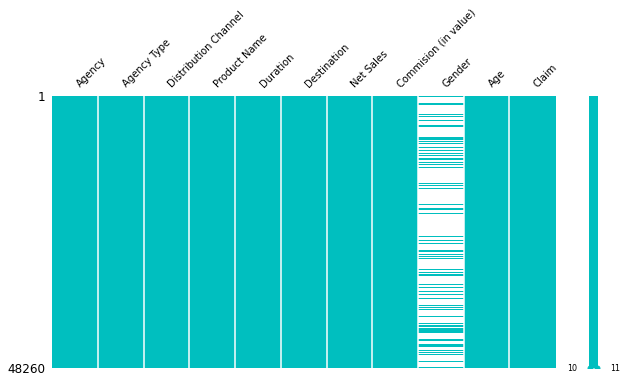

In [8]:
# Visualization of missing values 
msno.matrix(ins, figsize=(10,5), fontsize=10, color=(0.0, 0.75, 0.75)) 

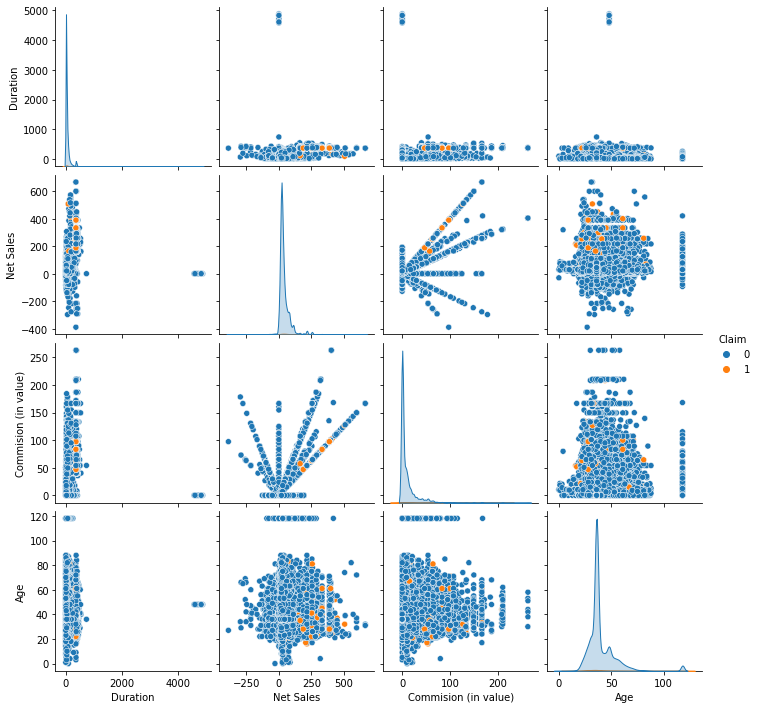

In [9]:
# Relations betwwen variables
sns.pairplot(ins, hue='Claim')

# 4. Preprocessing and feature engineering

Changes in the testing data are executed in order to maintain a consistent shape with the training data. Since 'Gender' has too many missing values and the 'Distribution Channel' is highly correlated to others variables and presents imbalanced classes, the entire columns will be removed. Outliers will be removed too. A new category, 'Other', will be created for attributes with smaller frequencies along the variables, in order to decreased the number of columns that will be created after one hot encoding the categorical variables.


In [10]:
# Droping irrelevants columns
ins.drop(['Gender', 'Distribution Channel'], axis=1, inplace=True)
test_ins.drop(['Gender', 'Distribution Channel'], axis=1, inplace=True)

# Transforming outliers into NaN for posterior imputation
ins['Duration']= ins.loc[:, 'Duration'].apply(lambda x: np.nan if x < 1 else x)
ins['Age']= ins.loc[:,'Age'].apply(lambda x: np.nan if x == 118 else x)

([0, 1, 2, 3, 4, 5, 6, 7, 8], <a list of 9 Text major ticklabel objects>)

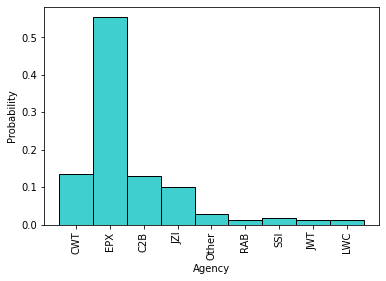

In [11]:
# AGENCY

# Replacing the agencies with a frequency smaller than 1% with 'Other' 
Agencies=ins.loc[:,'Agency'].value_counts(normalize=True)*100
Agencies=list(Agencies[Agencies < 1].index)
ins.loc[:,'Agency']=ins.loc[:,'Agency'].apply(lambda i: 'Other' if i in Agencies else i)
test_ins.loc[:,'Agency']=test_ins.loc[:,'Agency'].apply(lambda i: 'Other' if i in Agencies else i)
sns.histplot(data=ins, x='Agency', color='c', stat='probability') # plot new categories
plt.xticks(rotation='vertical')

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 <a list of 11 Text major ticklabel objects>)

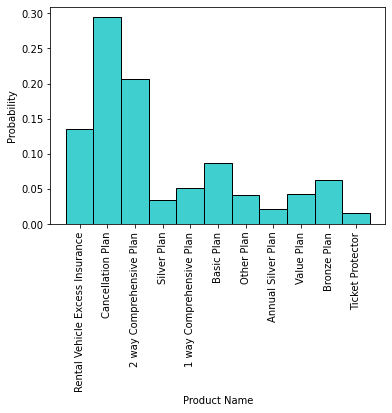

In [12]:
# PRODUCT NAME

# Replacing the products with a frequency smaller than 1% with 'Other Plan' 
Products=ins.loc[:, 'Product Name'].value_counts(normalize=True)*100
Products=list(Products[Products < 1].index)
ins['Product Name']=ins['Product Name'].apply(lambda i: 'Other Plan' if i in Products else i)
test_ins['Product Name']=test_ins['Product Name'].apply(lambda i: 'Other Plan' if i in Products else i)
sns.histplot(data=ins, x='Product Name', color='c', stat='probability')  # plot new categories
plt.xticks(rotation='vertical')


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17],
 <a list of 18 Text major ticklabel objects>)

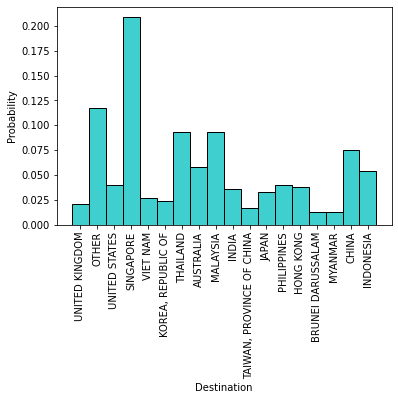

In [13]:
# DESTINATION

# Replacing the Destinations with a frequency smaller than 1% to 'OTHER'
Destination=ins.loc[:, 'Destination'].value_counts(normalize=True)*100
Destination=list(Destination[Destination > 1].index)

ins['Destination']=ins['Destination'].apply(lambda i: 'OTHER' if i not in Destination else i)
test_ins['Destination']=test_ins['Destination'].apply(lambda i: 'OTHER' if i not in Destination else i)

sns.histplot(data=ins, x='Destination', color='c', stat='probability')  # plot new categories
plt.xticks(rotation='vertical')


In [14]:
# Checking the shape of the data for modeling
ins.shape
test_ins.shape

(48260, 9)

(15832, 8)

# 5. Modeling experiments
As it's seen in the Statistical Report, the positive cases (1) of 'Claim' are only 1.5% of the target variable, and the negative cases (0) are 98.5%. To deal with these highly imbalanced classes, I will oversample the minority class with [SMOTE](https://imbalanced-learn.org/stable/over_sampling.html), and then I will try models with outlier/anomaly detection techniques and a simple neural network.  I will not register the experiments with the data without oversampling if the results are worse than with oversampling. 

In [15]:
# Function for preprocessing the data

def prep(X):

  num_var = X[['Duration', 'Net Sales', 'Commision (in value)', 'Age']]
  cat_var = X[['Agency', 'Agency Type', 'Product Name', 'Destination']]

  # Imputing missing values
  imputed= SimpleImputer(missing_values=np.nan, strategy='mean').fit_transform(num_var)
  imputed = pd.DataFrame(data=imputed)
  imputed.columns= num_var.columns
  
  # One hot encoding categorial variables
  one = pd.get_dummies(cat_var, columns=cat_var.columns, drop_first=True)

  # Join
  join = pd.concat([imputed, one], axis=1)

  # Normalizing data
  normal_features = MinMaxScaler().fit_transform(join)
  normal_features = pd.DataFrame(data=normal_features)
  normal_features.columns= join.columns
  
  return normal_features

In [16]:
# Spliting data into training and validation datasets

X = prep(ins)
y = ins['Claim']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2,stratify=y, random_state=2021)
X_test = prep(test_ins)
# y_test is on the Dphi site

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape)

(38608, 40) (38608,)
(9652, 40) (9652,)
(15832, 40)


In [17]:
# Oversampling with SMOTE (50% of minority class)
X_resampled, y_resampled = SMOTE(sampling_strategy=0.5, random_state=2021).fit_resample(X_train, y_train)
y_resampled.value_counts()

0    38042
1    19021
Name: Claim, dtype: int64

## 5.1 Modeling with Isolation Forest

Isolation forest is an unsupervised algorithm for anomaly detection that works on principle of isolating anomalies. Instead of trying to build a model of normal instances, it explicitly isolates anomalous points in the dataset. It is a very fast algorithm with a low memory demand.

 For anomaly detection, scikit-learn marks inliers as 1, and outliers as -1, whereas this dataset has marked them 0 and 1, respectively, so I will rename them.

In [18]:
y_train_isf = y_resampled.replace({0: 1, 1: -1})
y_val_isf = y_val.replace({0: 1, 1: -1})

In [19]:
# Calculating outlier fraction
train = pd.concat([X_resampled, y_train_isf], axis=1)
claim_train = train[train['Claim'] == -1] # outliers
no_claim_train = train[train['Claim'] == 1] # inliers

outlier_fraction = len(claim_train)/float(len(no_claim_train))
outlier_fraction

0.5

In [20]:
# Creating the isolation forest model
isf = IsolationForest(max_samples = len(X_resampled), contamination = outlier_fraction, n_estimators=1000, random_state=2021, n_jobs=-1)
isf.fit(X_resampled)

IsolationForest(contamination=0.5, max_samples=57063, n_estimators=1000,
                n_jobs=-1, random_state=2021)

In [21]:
# Anomaly score of the input samples. The lower, the more abnormal
isf.score_samples(X_resampled)

array([-0.39372302, -0.36047495, -0.3547581 , ..., -0.35598479,
       -0.37386896, -0.35124289])

In [22]:
# Evaluating the model
print('Train accuracy:', accuracy_score(y_train_isf, isf.predict(X_resampled)))
print(' ')
print('Validation accuracy:', accuracy_score(y_val_isf, isf.predict(X_val)))
print(' ')
print(classification_report(y_val_isf, isf.predict(X_val)))

Train accuracy: 0.446261149957065
 
Validation accuracy: 0.45814338997099047
 
              precision    recall  f1-score   support

          -1       0.01      0.42      0.02       142
           1       0.98      0.46      0.63      9510

    accuracy                           0.46      9652
   macro avg       0.50      0.44      0.32      9652
weighted avg       0.97      0.46      0.62      9652



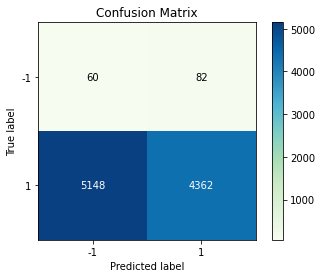

In [23]:
# Confusion Matrix
skplt.metrics.plot_confusion_matrix(y_val_isf, isf.predict(X_val), cmap='GnBu')

As the metrics show, Isolation forests don't perform well in this particular dataset, mainly because they work better when outliers are 'separated' from the rest of the data and this is not the case, as the pair plot at the beginning shows; so results like these were somehow expected.

## 5.2 Modeling with Neural Networks

I will create a simple neural network for binary classification with L2 regularization using Tensorflow 2. 

In [24]:
# Building the model
decay = 1e-4

model = Sequential()
model.add(Dense(40, activation='relu', input_shape=(X_resampled.shape[1],)))   
model.add(Dense(32, activation='relu',  kernel_regularizer=regularizers.l2(decay))) 
model.add(Dense(16, activation='relu', kernel_regularizer=regularizers.l2(decay)))
model.add(Dense(8, activation='relu', kernel_regularizer=regularizers.l2(decay)))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 40)                1640      
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1312      
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 9         
Total params: 3,625
Trainable params: 3,625
Non-trainable params: 0
_________________________________________________________________


In [25]:
# Compiling the model
model.compile(loss='binary_crossentropy', optimizer= 'adam')

In [26]:
# Fitting the model
history=model.fit(X_resampled, y_resampled, batch_size=373, epochs=200, validation_data=(X_val,y_val))

Epoch 1/200
153/153 [==============================] - 2s 6ms/step - loss: 0.5845 - val_loss: 0.3528
Epoch 2/200
153/153 [==============================] - 0s 2ms/step - loss: 0.4613 - val_loss: 0.3085
Epoch 3/200
153/153 [==============================] - 0s 2ms/step - loss: 0.4493 - val_loss: 0.3354
Epoch 4/200
153/153 [==============================] - 0s 2ms/step - loss: 0.4399 - val_loss: 0.3273
Epoch 5/200
153/153 [==============================] - 0s 2ms/step - loss: 0.4338 - val_loss: 0.3500
Epoch 6/200
153/153 [==============================] - 0s 2ms/step - loss: 0.4297 - val_loss: 0.3398
Epoch 7/200
153/153 [==============================] - 0s 2ms/step - loss: 0.4215 - val_loss: 0.3487
Epoch 8/200
153/153 [==============================] - 0s 2ms/step - loss: 0.4148 - val_loss: 0.2944
Epoch 9/200
153/153 [==============================] - 0s 2ms/step - loss: 0.4149 - val_loss: 0.3347
Epoch 10/200
153/153 [==============================] - 0s 2ms/step - loss: 0.4033 - val_lo

Text(0.5, 1.0, 'Model Loss')

Text(0, 0.5, 'loss')

Text(0.5, 0, 'epoch')

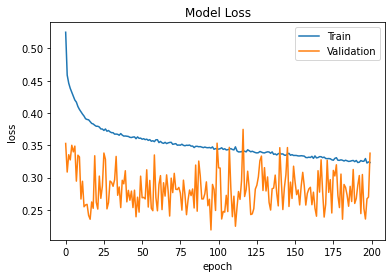

In [27]:
# Plot losses
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'])
plt.show()

In [28]:
# Predictions
validation=np.array(X_val)
predictions_nn=(model.predict(X_val)>0.5).astype("int32")

# Classification report
print(classification_report(y_val, predictions_nn, target_names=['0','1']))


              precision    recall  f1-score   support

           0       0.99      0.84      0.91      9510
           1       0.05      0.61      0.10       142

    accuracy                           0.83      9652
   macro avg       0.52      0.73      0.50      9652
weighted avg       0.98      0.83      0.90      9652



As the metrics show, the neural network performs better than the Isolation Forest in classifying the minority class (1),  but is not better than the traditional classification models if the F1 score for minority class is the final evaluation metric (traditional models got 0.12 in f1-score).

## 5.3 Modeling with Autoencoders

I will use Tensorflow 2 and Keras to build an Autoencoder. The benefit of this type of model is that it's trained considering only one target class (or 'normal' data), so when it's exposed to more classes (or 'anomalous' data), the model detects them as anomalies.


In [29]:
# Redefining the training and validation data

y_resampled = y_resampled.astype(bool)
y_val = y_val.astype(bool)

# Normal data is when the insurance is not claim, Claim = 0
normal_train_data = X_resampled[~y_resampled]
normal_test_data = X_val[~y_val]

# Anomalous data is when the insurance is claim, Claim = 1
anomalous_train_data = X_resampled[y_resampled]
anomalous_test_data = X_val[y_val]

In [30]:
# Building the model

class AnomalyDetector(Model):
  def __init__(self):
    super(AnomalyDetector, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Dense(32, activation="relu"),
      layers.Dense(16, activation="relu"),
      layers.Dense(8, activation="relu")])

    self.decoder = tf.keras.Sequential([
      layers.Dense(16, activation="relu"),
      layers.Dense(32, activation="relu"),
      layers.Dense(40, activation="sigmoid")])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = AnomalyDetector()

In [31]:
# Compile the model
autoencoder.compile(optimizer='adam', loss='mse')

In [32]:
history = autoencoder.fit(normal_train_data, normal_train_data, 
          epochs=50, 
          batch_size=373,
          validation_data=(X_val, X_val),
          shuffle=True)

Epoch 1/50
102/102 [==============================] - 1s 6ms/step - loss: 0.2031 - val_loss: 0.0601
Epoch 2/50
102/102 [==============================] - 0s 3ms/step - loss: 0.0568 - val_loss: 0.0423
Epoch 3/50
102/102 [==============================] - 0s 3ms/step - loss: 0.0384 - val_loss: 0.0302
Epoch 4/50
102/102 [==============================] - 0s 3ms/step - loss: 0.0291 - val_loss: 0.0257
Epoch 5/50
102/102 [==============================] - 0s 3ms/step - loss: 0.0247 - val_loss: 0.0216
Epoch 6/50
102/102 [==============================] - 0s 3ms/step - loss: 0.0211 - val_loss: 0.0189
Epoch 7/50
102/102 [==============================] - 0s 3ms/step - loss: 0.0185 - val_loss: 0.0177
Epoch 8/50
102/102 [==============================] - 0s 3ms/step - loss: 0.0174 - val_loss: 0.0164
Epoch 9/50
102/102 [==============================] - 0s 3ms/step - loss: 0.0163 - val_loss: 0.0160
Epoch 10/50
102/102 [==============================] - 0s 3ms/step - loss: 0.0160 - val_loss: 0.0158

Text(0.5, 1.0, 'Model Loss')

Text(0, 0.5, 'loss')

Text(0.5, 0, 'epoch')

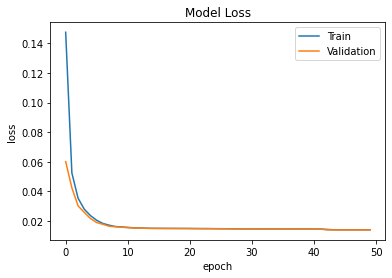

In [33]:
# Plot losses
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'])
plt.show()

(array([1.8275e+04, 2.0000e+01, 9.0000e+00, 5.0000e+00, 5.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.7720e+04, 6.7800e+02, 9.2000e+01, 2.1000e+01,
        1.1000e+01, 7.0000e+00, 1.0000e+00, 4.0000e+00, 2.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 8.8500e+02, 1.7000e+01, 2.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 3.0000e+00, 5.0000e+00, 2.7800e+02]),
 array([6.75239540e-08, 1.52772200e-03, 3.05537647e-03, 4.58303095e-03,
        6.11068542e-03, 7.63833990e-03, 9.16599437e-03, 1.06936488e-02,
        1.22213033e-02, 1.37489578e-02, 1.52766123e-02, 1.68042667e-02,
        1.83319212e-02, 1.98595757e-02, 2.13872302e-02, 2.29148846e-02,
        2.44425391e-02, 2.5970

Text(0.5, 0, 'Train loss')

Text(0, 0.5, 'No of examples')

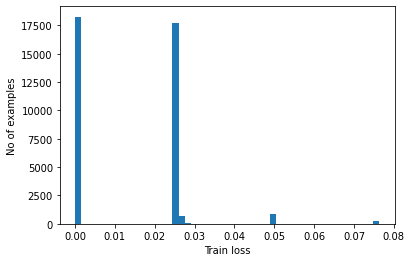

In [34]:
# Reconstructions errpr for normal data
reconstructions = autoencoder.predict(normal_train_data)
train_loss = tf.keras.losses.mse(reconstructions, normal_train_data)

plt.hist(train_loss, bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

In [35]:
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)

Threshold:  0.028626657022797194


(array([47.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0., 62., 21.,  1.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  4.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  4.]),
 array([1.88573597e-06, 1.51489752e-03, 3.02790930e-03, 4.54092108e-03,
        6.05393286e-03, 7.56694463e-03, 9.07995641e-03, 1.05929682e-02,
        1.21059800e-02, 1.36189918e-02, 1.51320035e-02, 1.66450153e-02,
        1.81580271e-02, 1.96710389e-02, 2.11840507e-02, 2.26970624e-02,
        2.42100742e-02, 2.57230860e-02, 2.72360978e-02, 2.87491096e-02,
        3.02621213e-02, 3.17751331e-02, 3.32881449e-02, 3.48011567e-02,
        3.63141685e-02, 3.78271802e-02, 3.93401920e-02, 4.08532038e-02,
        4.23662156e-02, 4.38792274e-02, 4.53922391e-02, 4.69052509e-02,
        4.84182627e-02, 4.99312745e-02, 5.14442862e-02, 5.29572980e-02,
        5.44703098e-02, 5.59833216e-02, 5.74963334e-02, 5.90093451e-

Text(0.5, 0, 'Test loss')

Text(0, 0.5, 'No of examples')

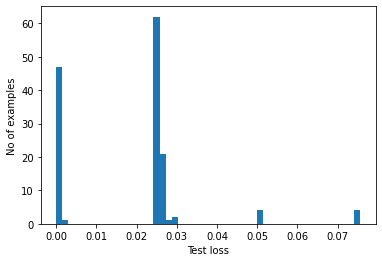

In [36]:
# Reconstruction errors for anomalous data
reconstructions = autoencoder.predict(anomalous_test_data)
test_loss = tf.keras.losses.mse(reconstructions, anomalous_test_data)

plt.hist(test_loss, bins=50)
plt.xlabel("Test loss")
plt.ylabel("No of examples")


In [37]:
# Functions to Classify  as an anomaly if the reconstruction error is greater than the threshold

def predict(model, data, threshold):
  reconstructions = model(data)
  loss = tf.keras.losses.mse(reconstructions, data)
  return tf.math.less(loss, threshold)

def print_stats(predictions, labels):
  print("Accuracy = {}".format(accuracy_score(labels, preds)))
  print(classification_report(y_val, preds, target_names=['0','1']))

In [38]:
# Evaluating the model
preds = predict(autoencoder, np.asarray(X_val), threshold)
print_stats(preds, y_val)

Accuracy = 0.04786572731040199
              precision    recall  f1-score   support

           0       0.97      0.03      0.07      9510
           1       0.01      0.93      0.03       142

    accuracy                           0.05      9652
   macro avg       0.49      0.48      0.05      9652
weighted avg       0.96      0.05      0.07      9652



Autoencoders get results similar to the Isolation Forest, since both are methods for anomaly detection, but this Autoencoder fails to correctly predict both classes, not only the minority one. Unfortunately, even with oversampled data, the results for these techniques are worse compared to classification models, as the F1 score for minority class can tell. 

# 6. Conclusions

In the first version of this project, the F1 score obtained for the validation data was 0.1216, and the F1 score obtained by uploading the final predictions for the test data at the Dphi website was 0.1143. The models tested in this project didn't get better results than those.

The Top 1 score in the Dphi's leaderboard is 0.1618, for a total of 188 participants. So I guess I could improve the performance of my models with hyperparameter tuning or better feature engineering, but since the F1 score is still low even for the first place, I can conclude that the data quality of the dataset used is bad, and an improvement is not worthy. 